<a href="https://colab.research.google.com/github/KarolineKlan/deep_project_group_38/blob/main/notebooks/dir_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The original one

In [13]:
from __future__ import print_function
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np

device = torch.device("cuda")


train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=256, shuffle=False)

ngf = 64
ndf = 64
nc = 1

def prior(K, alpha):
    """
    Prior for the model.
    :K: number of categories
    :alpha: Hyper param of Dir
    :return: mean and variance tensors
    """
    # ラプラス近似で正規分布に近似
    # Approximate to normal distribution using Laplace approximation
    a = torch.Tensor(1, K).float().fill_(alpha)
    mean = a.log().t() - a.log().mean(1)
    var = ((1 - 2.0 / K) * a.reciprocal()).t() + (1.0 / K ** 2) * a.reciprocal().sum(1)
    return mean.t(), var.t() # Parameters of prior distribution after approximation

class Dir_VAE(nn.Module):
    def __init__(self):
        super(Dir_VAE, self).__init__()
        self.encoder = nn.Sequential(
            # input is (nc) x 28 x 28
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 14 x 14
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 7 x 7
            nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1024, 4, 1, 0, bias=False),
            # nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.Sigmoid()
        )

        self.decoder = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     1024, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     nc, 4, 2, 1, bias=False),
            # nn.BatchNorm2d(ngf),
            # nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            # nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            # nn.Tanh()
            nn.Sigmoid()
            # state size. (nc) x 64 x 64
        )
        self.fc1 = nn.Linear(1024, 512)
        self.fc21 = nn.Linear(512, 10)
        self.fc22 = nn.Linear(512, 10)

        self.fc3 = nn.Linear(10, 512)
        self.fc4 = nn.Linear(512, 1024)

        self.lrelu = nn.LeakyReLU()
        self.relu = nn.ReLU()

        # Dir prior
        self.prior_mean, self.prior_var = map(nn.Parameter, prior(10, 0.3)) # 0.3 is a hyper param of Dirichlet distribution
        self.prior_logvar = nn.Parameter(self.prior_var.log())
        self.prior_mean.requires_grad = False
        self.prior_var.requires_grad = False
        self.prior_logvar.requires_grad = False


    def encode(self, x):
        conv = self.encoder(x);
        h1 = self.fc1(conv.view(-1, 1024))
        return self.fc21(h1), self.fc22(h1)

    def decode(self, gauss_z):
        dir_z = F.softmax(gauss_z,dim=1)
        # This variable (z) can be treated as a variable that follows a Dirichlet distribution (a variable that can be interpreted as a probability that the sum is 1)
        # Use the Softmax function to satisfy the simplex constraint
        # シンプレックス制約を満たすようにソフトマックス関数を使用
        h3 = self.relu(self.fc3(dir_z))
        deconv_input = self.fc4(h3)
        deconv_input = deconv_input.view(-1,1024,1,1)
        return self.decoder(deconv_input)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std


    def forward(self, x):
        mu, logvar = self.encode(x)
        gauss_z = self.reparameterize(mu, logvar)
        # gause_z is a variable that follows a multivariate normal distribution
        # Inputting gause_z into softmax func yields a random variable that follows a Dirichlet distribution (Softmax func are used in decoder)
        dir_z = F.softmax(gauss_z,dim=1) # This variable follows a Dirichlet distribution
        return self.decode(gauss_z), mu, logvar, gauss_z, dir_z

    # Reconstruction + KL divergence losses summed over all elements and batch
    def loss_function(self, recon_x, x, mu, logvar, K):
        beta = 1.0
        BCE = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
        # ディリクレ事前分布と変分事後分布とのKLを計算
        # Calculating KL with Dirichlet prior and variational posterior distributions
        # Original paper:"Autoencodeing variational inference for topic model"-https://arxiv.org/pdf/1703.01488
        prior_mean = self.prior_mean.expand_as(mu)
        prior_var = self.prior_var.expand_as(logvar)
        prior_logvar = self.prior_logvar.expand_as(logvar)
        var_division = logvar.exp() / prior_var # Σ_0 / Σ_1
        diff = mu - prior_mean # μ_１ - μ_0
        diff_term = diff *diff / prior_var # (μ_1 - μ_0)(μ_1 - μ_0)/Σ_1
        logvar_division = prior_logvar - logvar # log|Σ_1| - log|Σ_0| = log(|Σ_1|/|Σ_2|)
        # KL
        KLD = 0.5 * ((var_division + diff_term + logvar_division).sum(1) - K)
        return BCE + KLD


model = Dir_VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar, gauss_z, dir_z = model(data)

        loss = model.loss_function(recon_batch, data, mu, logvar, 10)
        loss = loss.mean()
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 10 == 0:
            #print(f"gause_z:{gauss_z[0]}")
            #print(f"dir_z:{dir_z[0]},SUM:{torch.sum(dir_z[0])}")
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar, gauss_z, dir_z = model(data)
            loss = model.loss_function(recon_batch, data, mu, logvar, 10)
            test_loss += loss.mean()
            test_loss.item()
            if i == 0:
                n = min(data.size(0), 18)
                #comparison = torch.cat([data[:n],
                #                      recon_batch.view(args.batch_size, 1, 28, 28)[:n]])
                #save_image(comparison.cpu(),
                #         'image/recon_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

# if __name__ == "__main__":
#     # 学習(Train)
#     for epoch in range(1, 10 + 1):
#         train(epoch)
#         test(epoch)
#         #with torch.no_grad():
#             #sample = torch.randn(64, args.category).to(device)
#             #sample = model.decode(sample).cpu()
#             #save_image(sample.view(64, 1, 28, 28),'image/sample_' + str(epoch) + '.png')


# ---------- History containers for curves ----------
epoch_train_bce, epoch_train_kld, epoch_train_total = [], [], []
epoch_test_bce,  epoch_test_kld,  epoch_test_total  = [], [], []

# ---------- Epoch-level evaluator that matches your original loss parts ----------
@torch.no_grad()
def evaluate_once_original(model, loader, K=10, device=device):
    model.eval()
    total_bce, total_kld, total_cnt = 0.0, 0.0, 0

    for x, _ in loader:
        x = x.to(device)
        recon_batch, mu, logvar, gauss_z, dir_z = model(x)

        # BCE exactly like your loss (sum over batch)
        bce = F.binary_cross_entropy(
            recon_batch.reshape(x.size(0), -1),
            x.reshape(x.size(0), -1),
            reduction="sum"
        )

        # KL exactly like your loss (sum over batch)
        prior_mean = model.prior_mean.expand_as(mu)
        prior_var = model.prior_var.expand_as(logvar)
        prior_logvar = model.prior_logvar.expand_as(logvar)

        var_division = logvar.exp() / prior_var        # Σ0 / Σ1
        diff = mu - prior_mean                         # μ1 - μ0
        diff_term = diff * diff / prior_var            # (μ1-μ0)^2 / Σ1
        logvar_division = prior_logvar - logvar        # log|Σ1| - log|Σ0|
        kld_vec = 0.5 * ((var_division + diff_term + logvar_division).sum(1) - K)
        kld = kld_vec.sum()

        total_bce += bce.item()
        total_kld += kld.item()
        total_cnt += x.size(0)

    # averages per sample (so curves are on the same scale regardless of batch size)
    bce_avg = total_bce / total_cnt
    kld_avg = total_kld / total_cnt
    tot_avg = (total_bce + total_kld) / total_cnt
    return bce_avg, kld_avg, tot_avg

# ------------------------------------------------------------
# Train (unchanged), but record metrics after each epoch
# ------------------------------------------------------------
num_epochs = 10  # or whatever you use above
for epoch in range(1, num_epochs + 1):
    train(epoch)
    test(epoch)
    # (optional) sample_from_prior here if you have it; your original code commented this out

    # ----- record metrics for plotting curves -----
    tr_bce, tr_kld, tr_tot = evaluate_once_original(model, train_loader, K=10, device=device)
    te_bce, te_kld, te_tot = evaluate_once_original(model, test_loader,  K=10, device=device)

    epoch_train_bce.append(tr_bce); epoch_train_kld.append(tr_kld); epoch_train_total.append(tr_tot)
    epoch_test_bce.append(te_bce);  epoch_test_kld.append(te_kld);  epoch_test_total.append(te_tot)

print("Done.")

# Make an epochs axis for your plots
epochs = range(1, len(epoch_train_total) + 1)


Train Epoch: 1 [0/60000 (0%)]	Loss: 820.324097
Train Epoch: 1 [2560/60000 (4%)]	Loss: 239.324890
Train Epoch: 1 [5120/60000 (9%)]	Loss: 218.415390
Train Epoch: 1 [7680/60000 (13%)]	Loss: 207.347046
Train Epoch: 1 [10240/60000 (17%)]	Loss: 198.613861
Train Epoch: 1 [12800/60000 (21%)]	Loss: 203.350815
Train Epoch: 1 [15360/60000 (26%)]	Loss: 197.913055
Train Epoch: 1 [17920/60000 (30%)]	Loss: 191.354034
Train Epoch: 1 [20480/60000 (34%)]	Loss: 194.148438
Train Epoch: 1 [23040/60000 (38%)]	Loss: 187.109085
Train Epoch: 1 [25600/60000 (43%)]	Loss: 184.417511
Train Epoch: 1 [28160/60000 (47%)]	Loss: 183.916245
Train Epoch: 1 [30720/60000 (51%)]	Loss: 176.747681
Train Epoch: 1 [33280/60000 (55%)]	Loss: 176.592560
Train Epoch: 1 [35840/60000 (60%)]	Loss: 171.482056
Train Epoch: 1 [38400/60000 (64%)]	Loss: 168.709198
Train Epoch: 1 [40960/60000 (68%)]	Loss: 169.187378
Train Epoch: 1 [43520/60000 (72%)]	Loss: 154.064636
Train Epoch: 1 [46080/60000 (77%)]	Loss: 153.868027
Train Epoch: 1 [48640/

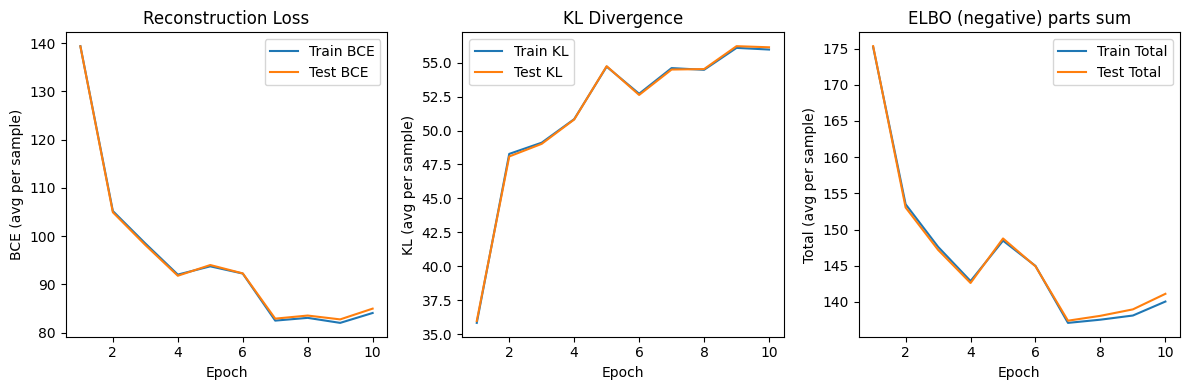

In [14]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(epochs, epoch_train_bce,  label="Train BCE")
plt.plot(epochs, epoch_test_bce,   label="Test BCE")
plt.xlabel("Epoch"); plt.ylabel("BCE (avg per sample)"); plt.title("Reconstruction Loss"); plt.legend()

plt.subplot(1,3,2)
plt.plot(epochs, epoch_train_kld, label="Train KL")
plt.plot(epochs, epoch_test_kld,  label="Test KL")
plt.xlabel("Epoch"); plt.ylabel("KL (avg per sample)"); plt.title("KL Divergence"); plt.legend()

plt.subplot(1,3,3)
plt.plot(epochs, epoch_train_total, label="Train Total")
plt.plot(epochs, epoch_test_total,  label="Test Total")
plt.xlabel("Epoch"); plt.ylabel("Total (avg per sample)"); plt.title("ELBO (negative) parts sum"); plt.legend()

plt.tight_layout()
plt.show()


# The one that runs

In [8]:
# ==== THE ONE THAT RUNS!!! ====

from __future__ import print_function
import os
from types import SimpleNamespace

import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

# ------------------------------------------------------------
# Safe seeding & debug knobs
# ------------------------------------------------------------
_ = torch.Generator(device='cpu').manual_seed(10)
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
torch.backends.cudnn.benchmark = False

# ------------------------------------------------------------
# Config
# ------------------------------------------------------------
config = SimpleNamespace(
    encoder_channels=64,
    decoder_channels=64,
    input_channels=1,
    latent_dim=1024,
    hidden_dim=512,
    category=10,     # Dirichlet dimension K
    alpha=0.3,       # symmetric prior alpha_0
    epochs=10,
    batch_size=256,
    learning_rate=1e-3,
    outdir="./image"
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    torch.cuda.manual_seed_all(10)

os.makedirs(config.outdir, exist_ok=True)

# ------------------------------------------------------------
# Data
# ------------------------------------------------------------
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST("./data", train=True, download=True, transform=transforms.ToTensor()),
    batch_size=config.batch_size, shuffle=True,
    num_workers=2, pin_memory=(device.type == "cuda")
)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST("./data", train=False, transform=transforms.ToTensor()),
    batch_size=config.batch_size, shuffle=False,
    num_workers=2, pin_memory=(device.type == "cuda")
)

# ------------------------------------------------------------
# Model
# ------------------------------------------------------------
class DirVAEEncoder(nn.Module):
    """Encoder producing Dirichlet parameters alpha_hat(x) > 0."""
    def __init__(self, cfg):
        super().__init__()
        ndf = cfg.encoder_channels
        nc = cfg.input_channels

        self.conv = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),      # -> (ndf) x 14 x 14
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False), # -> (ndf*2) x 7 x 7
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False),  # -> (ndf*4) x 4 x 4
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, cfg.latent_dim, 4, 1, 0, bias=False),  # -> (latent_dim) x 1 x 1
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.fc1 = nn.Linear(cfg.latent_dim, cfg.hidden_dim)
        self.fc_alpha = nn.Linear(cfg.hidden_dim, cfg.category)  # raw → softplus → alpha_hat

    def forward(self, x):
        h = self.conv(x).view(x.size(0), -1)
        h = self.fc1(h)
        alpha_raw = self.fc_alpha(h)
        alpha_hat = F.softplus(alpha_raw) + 1e-6
        alpha_hat = alpha_hat.clamp_min(1e-4).clamp_max(50.0)
        return alpha_hat

class DirVAEDecoder(nn.Module):
    """Decoder that takes simplex latent (Dirichlet sample) and reconstructs MNIST."""
    def __init__(self, cfg):
        super().__init__()
        ngf = cfg.decoder_channels
        nc = cfg.input_channels

        self.fc_decode = nn.Linear(cfg.category, cfg.hidden_dim)
        self.fc_deconv  = nn.Linear(cfg.hidden_dim, cfg.latent_dim)

        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(cfg.latent_dim, ngf * 8, 4, 1, 0, bias=False),  # 1 -> 4
            nn.BatchNorm2d(ngf * 8), nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 3, 2, 1, bias=False),         # 4 -> 7
            nn.BatchNorm2d(ngf * 4), nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),         # 7 -> 14
            nn.BatchNorm2d(ngf * 2), nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 2, nc, 4, 2, 1, bias=False),              # 14 -> 28
            nn.Sigmoid()
        )

    def forward(self, dir_z):
        h = F.relu(self.fc_decode(dir_z))
        d = self.fc_deconv(h).view(-1, self.fc_deconv.out_features, 1, 1)
        out = self.deconv(d)                        # expect (B, 1, 28, 28)
        # robust: if size drifts (e.g., 26/30), force to 28x28
        if out.shape[-1] != 28:
            out = F.interpolate(out, size=(28, 28), mode="bilinear", align_corners=False)
        return out.contiguous()

class DirVAE(nn.Module):
    """
    Dirichlet VAE:
      - Encoder -> alpha_hat(x) > 0
      - Reparameterized sampling via Gamma(alpha_hat, 1).rsample() then normalize
      - KL( Dir(alpha_hat) || Dir(alpha0) ) closed form
    """
    def __init__(self, cfg, device):
        super().__init__()
        self.cfg = cfg
        self.device = device

        self.encoder = DirVAEEncoder(cfg)
        self.decoder = DirVAEDecoder(cfg)

        # symmetric Dirichlet prior alpha0
        alpha0 = torch.full((1, cfg.category), cfg.alpha, dtype=torch.float)
        self.register_buffer("alpha_prior", alpha0)

    def encode(self, x):
        return self.encoder(x)  # alpha_hat

    def rsample_dirichlet(self, alpha_hat):
        # Reparameterized Gamma sampling
        alpha = alpha_hat.clamp_min(1e-4).clamp_max(50.0)
        x = torch.distributions.Gamma(alpha, torch.ones_like(alpha)).rsample()
        z = x / (x.sum(dim=1, keepdim=True) + 1e-12)
        return z

    def decode(self, dir_z):
        return self.decoder(dir_z)

    def forward(self, x):
        alpha_hat = self.encode(x)                 # (B,K)
        dir_z = self.rsample_dirichlet(alpha_hat)  # (B,K), simplex
        recon = self.decode(dir_z)                 # (B,1,28,28)
        return recon, alpha_hat, dir_z

    def kl_dirichlet(self, alpha_hat):
        """
        KL( Dir(alpha_hat) || Dir(alpha0) ), batch-wise.
        KL = log Γ(Σα̂) - log Γ(Σα0) - Σ[log Γ(α̂_k) - log Γ(α0_k)]
             + Σ(α̂_k - α0_k) * [ψ(α̂_k) - ψ(Σα̂)]
        """
        alpha_hat = alpha_hat.clamp_min(1e-4).clamp_max(50.0)
        alpha0 = self.alpha_prior.expand_as(alpha_hat)
        sum_a  = alpha_hat.sum(dim=1)
        sum_a0 = alpha0.sum(dim=1)

        term1 = torch.lgamma(sum_a) - torch.lgamma(sum_a0)
        term2 = (torch.lgamma(alpha_hat) - torch.lgamma(alpha0)).sum(dim=1)
        psi_a = torch.special.digamma(alpha_hat)
        psi_sum_a = torch.special.digamma(sum_a).unsqueeze(1)
        term3 = ((alpha_hat - alpha0) * (psi_a - psi_sum_a)).sum(dim=1)
        return term1 - term2 + term3  # shape (B,)

    def loss_parts(self, recon, x, alpha_hat):
        bce = F.binary_cross_entropy(
            recon.reshape(x.size(0), -1),
            x.reshape(x.size(0), -1),
            reduction="sum"
        )
        kld = self.kl_dirichlet(alpha_hat).sum()
        return bce, kld

# ------------------------------------------------------------
# Instantiate model & optimizer
# ------------------------------------------------------------
model = DirVAE(config, device).to(device)
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

print(f"Device: {device}")
print(f"Trainable params: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

# ------------------------------------------------------------
# Training utilities
# ------------------------------------------------------------
def kl_beta(epoch, total_epochs, ramp_frac=0.3, max_beta=1.0):
    ramp = max(1, int(ramp_frac * total_epochs))
    return min(max_beta, epoch / ramp)

def train(epoch):
    model.train()
    beta = kl_beta(epoch, config.epochs)  # set to 1.0 to disable warm-up
    total = 0.0

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)

        recon, alpha_hat, dir_z = model(data)

        if not torch.isfinite(alpha_hat).all():
            raise RuntimeError("alpha_hat contains NaN/Inf")
        if not torch.isfinite(recon).all():
            raise RuntimeError("recon contains NaN/Inf")

        bce, kld = model.loss_parts(recon, data, alpha_hat)
        loss = bce + beta * kld

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()

        total += loss.item()

        if batch_idx % 10 == 0:
            print(
                f"Train Epoch: {epoch} "
                f"[{batch_idx * len(data):5d}/{len(train_loader.dataset)} "
                f"({100. * batch_idx / len(train_loader):3.0f}%)]  "
                f"Loss: {(loss.item()/len(data)):.4f}  "
                f"(BCE: {(bce.item()/len(data)):.4f}, KL: {(kld.item()/len(data)):.4f}, beta={beta:.2f})"
            )

    avg = total / len(train_loader.dataset)
    print(f"====> Epoch {epoch}  Average train loss: {avg:.4f}")
    return avg

def test(epoch):
    model.eval()
    total = 0.0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon, alpha_hat, dir_z = model(data)
            bce, kld = model.loss_parts(recon, data, alpha_hat)
            loss = bce + kld
            total += loss.item()

            if i == 0:
                n = min(data.size(0), 18)
                comparison = torch.cat([data[:n], recon[:n]])
                save_image(comparison.cpu(), os.path.join(config.outdir, f"recon_{epoch}.png"), nrow=n)

    avg = total / len(test_loader.dataset)
    print(f"====> Test  Average loss: {avg:.4f}")
    return avg

def sample_from_prior(epoch, n=64):
    model.eval()
    with torch.no_grad():
        alpha0 = model.alpha_prior.expand(n, -1)
        x = torch.distributions.Gamma(alpha0, torch.ones_like(alpha0)).rsample().to(device)
        z = x / (x.sum(dim=1, keepdim=True) + 1e-12)
        imgs = model.decode(z).cpu()
        save_image(imgs, os.path.join(config.outdir, f"sample_{epoch}.png"), nrow=8)

# ------------------------------------------------------------
# Train
# ------------------------------------------------------------
# ---------- ADD THESE JUST BEFORE THE EPOCH LOOP ----------
# history lists (the plotting cell expects these names)
epoch_train_bce, epoch_train_kld, epoch_train_total = [], [], []
epoch_test_bce,  epoch_test_kld,  epoch_test_total  = [], [], []

def evaluate_once(model, loader):
    """Return (BCE_avg, KL_avg, Total_avg) over a loader."""
    model.eval()
    total_bce = 0.0
    total_kld = 0.0
    total_cnt = 0
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)
            recon, alpha_hat, _ = model(x)
            bce, kld = model.loss_parts(recon, x, alpha_hat)  # sums over batch
            total_bce += bce.item()
            total_kld += kld.item()
            total_cnt += x.size(0)
    return (total_bce / total_cnt, total_kld / total_cnt, (total_bce + total_kld) / total_cnt)


for epoch in range(1, config.epochs + 1):
    train(epoch)
    test(epoch)
    sample_from_prior(epoch)

    # record averaged metrics for plotting curves
    tr_bce, tr_kld, tr_tot = evaluate_once(model, train_loader)
    te_bce, te_kld, te_tot = evaluate_once(model, test_loader)

    epoch_train_bce.append(tr_bce); epoch_train_kld.append(tr_kld); epoch_train_total.append(tr_tot)
    epoch_test_bce.append(te_bce);  epoch_test_kld.append(te_kld);  epoch_test_total.append(te_tot)

print("Done.")


Device: cuda
Trainable params: 15779338
Train Epoch: 1 [    0/60000 (  0%)]  Loss: 1102.2656  (BCE: 1101.6667, KL: 1.7966, beta=0.33)
Train Epoch: 1 [ 2560/60000 (  4%)]  Loss: 219.0504  (BCE: 217.3076, KL: 5.2283, beta=0.33)
Train Epoch: 1 [ 5120/60000 (  9%)]  Loss: 204.5618  (BCE: 203.3511, KL: 3.6322, beta=0.33)
Train Epoch: 1 [ 7680/60000 ( 13%)]  Loss: 204.0569  (BCE: 202.5590, KL: 4.4937, beta=0.33)
Train Epoch: 1 [10240/60000 ( 17%)]  Loss: 197.5861  (BCE: 196.0394, KL: 4.6402, beta=0.33)
Train Epoch: 1 [12800/60000 ( 21%)]  Loss: 196.9725  (BCE: 193.7726, KL: 9.5997, beta=0.33)
Train Epoch: 1 [15360/60000 ( 26%)]  Loss: 190.6044  (BCE: 187.3734, KL: 9.6928, beta=0.33)
Train Epoch: 1 [17920/60000 ( 30%)]  Loss: 185.5616  (BCE: 182.1479, KL: 10.2411, beta=0.33)
Train Epoch: 1 [20480/60000 ( 34%)]  Loss: 176.1766  (BCE: 171.9568, KL: 12.6593, beta=0.33)
Train Epoch: 1 [23040/60000 ( 38%)]  Loss: 174.5124  (BCE: 169.9511, KL: 13.6840, beta=0.33)
Train Epoch: 1 [25600/60000 ( 43%)]

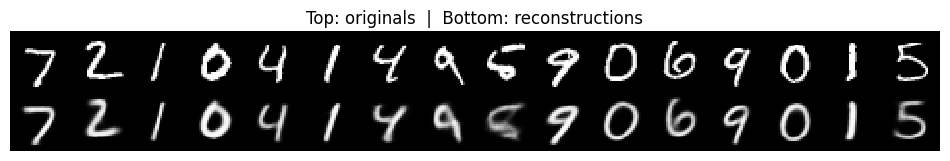

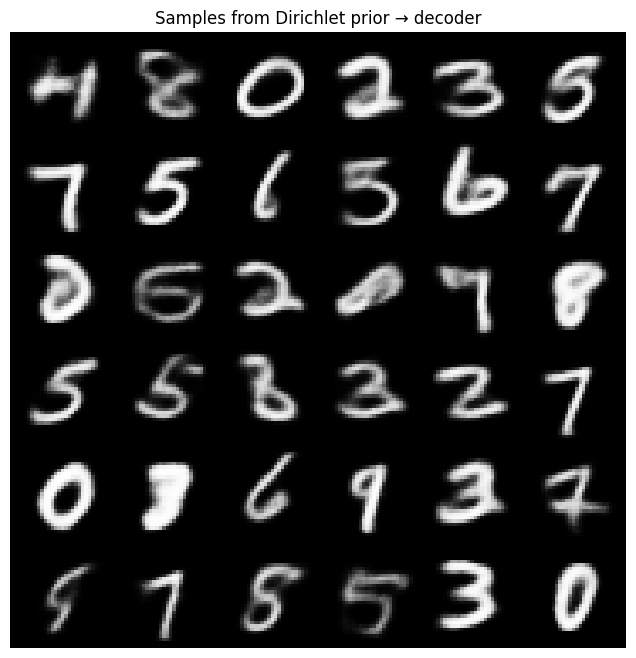

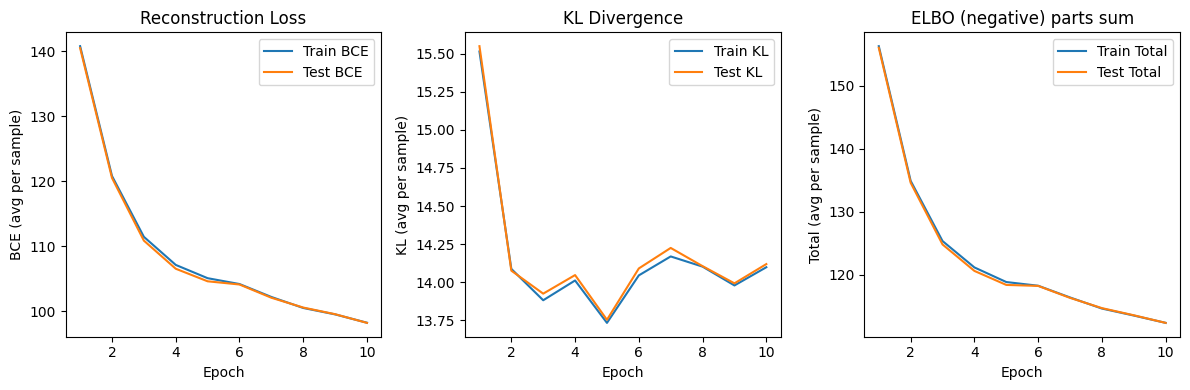

In [9]:
# ==== Visualizations & Curves (run in a new cell) ====
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import numpy as np

device = next(model.parameters()).device  # use same device as model

# ---------------------------
# 1) Show originals vs reconstructions
# ---------------------------
def show_recons(n=16):
    model.eval()
    with torch.no_grad():
        data, _ = next(iter(test_loader))
        data = data.to(device)
        recon, alpha_hat, dir_z = model(data)

        # take first n
        data_n  = data[:n].cpu()
        recon_n = recon[:n].cpu()

        grid = make_grid(torch.cat([data_n, recon_n], dim=0), nrow=n, padding=2)
        plt.figure(figsize=(12, 4))
        plt.title("Top: originals  |  Bottom: reconstructions")
        plt.axis("off")
        plt.imshow(grid.permute(1, 2, 0).squeeze(), interpolation="nearest")
        plt.show()

show_recons(n=16)

# ---------------------------
# 2) Show prior samples from Dirichlet
# ---------------------------
def show_prior_samples(n=32):
    model.eval()
    with torch.no_grad():
        alpha0 = model.alpha_prior.expand(n, -1)
        x = torch.distributions.Gamma(alpha0, torch.ones_like(alpha0)).rsample().to(device)
        z = x / (x.sum(dim=1, keepdim=True) + 1e-12)
        imgs = model.decode(z).cpu()

        grid = make_grid(imgs, nrow=int(np.sqrt(n)) if int(np.sqrt(n))**2 == n else 8, padding=2)
        plt.figure(figsize=(8, 8))
        plt.title("Samples from Dirichlet prior → decoder")
        plt.axis("off")
        plt.imshow(grid.permute(1, 2, 0).squeeze(), interpolation="nearest")
        plt.show()

show_prior_samples(n=36)

# ---------------------------
# 3) Loss curves (BCE, KL, Total)
#    - If you kept history arrays during training, this will plot them.
#    - Otherwise, it will compute a single point for the current model.
# ---------------------------
def evaluate_once(model, loader):
    model.eval()
    total_bce = 0.0
    total_kld = 0.0
    total_cnt = 0
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)
            recon, alpha_hat, _ = model(x)
            bce, kld = model.loss_parts(recon, x, alpha_hat)  # sums
            total_bce += bce.item()
            total_kld += kld.item()
            total_cnt += x.size(0)
    # average per sample
    return (total_bce / total_cnt, total_kld / total_cnt, (total_bce + total_kld) / total_cnt)

# Try to use history if present; else compute one-point “now” metrics
# You can populate these lists in your training loop if you want full curves:
#   epoch_train_bce, epoch_train_kld, epoch_train_total
#   epoch_test_bce,  epoch_test_kld,  epoch_test_total
have_history = all(name in globals() for name in [
    "epoch_train_bce", "epoch_train_kld", "epoch_train_total",
    "epoch_test_bce",  "epoch_test_kld",  "epoch_test_total"
])

if not have_history:
    print("No saved history found — computing current metrics once.")
    tr_bce, tr_kld, tr_tot = evaluate_once(model, train_loader)
    te_bce, te_kld, te_tot = evaluate_once(model, test_loader)
    epoch_train_bce  = [tr_bce]; epoch_train_kld  = [tr_kld]; epoch_train_total  = [tr_tot]
    epoch_test_bce   = [te_bce]; epoch_test_kld   = [te_kld]; epoch_test_total   = [te_tot]

epochs = range(1, len(epoch_train_total) + 1)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(epochs, epoch_train_bce,  label="Train BCE")
plt.plot(epochs, epoch_test_bce,   label="Test BCE")
plt.xlabel("Epoch"); plt.ylabel("BCE (avg per sample)"); plt.title("Reconstruction Loss"); plt.legend()

plt.subplot(1,3,2)
plt.plot(epochs, epoch_train_kld, label="Train KL")
plt.plot(epochs, epoch_test_kld,  label="Test KL")
plt.xlabel("Epoch"); plt.ylabel("KL (avg per sample)"); plt.title("KL Divergence"); plt.legend()

plt.subplot(1,3,3)
plt.plot(epochs, epoch_train_total, label="Train Total")
plt.plot(epochs, epoch_test_total,  label="Test Total")
plt.xlabel("Epoch"); plt.ylabel("Total (avg per sample)"); plt.title("ELBO (negative) parts sum"); plt.legend()

plt.tight_layout()
plt.show()
